Model copied to: /kaggle/working/final_model


2026-01-09 12:29:40.203825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767961780.390021      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767961780.445532      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767961780.899797      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767961780.899834      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767961780.899836      24 computation_placer.cc:177] computation placer alr

 Test samples: 254
Label distribution:
1    129
0    125
Name: count, dtype: int64

===== TEST METRICS (CROSS-DATASET) =====
Accuracy          : 0.7559
F1 (macro)        : 0.7444
F1 (weighted)     : 0.7435
Precision (macro) : 0.8220
Recall (macro)    : 0.7594

Classification Report:
              precision    recall  f1-score   support

           0     0.6721    0.9840    0.7987       125
           1     0.9718    0.5349    0.6900       129

    accuracy                         0.7559       254
   macro avg     0.8220    0.7594    0.7444       254
weighted avg     0.8243    0.7559    0.7435       254



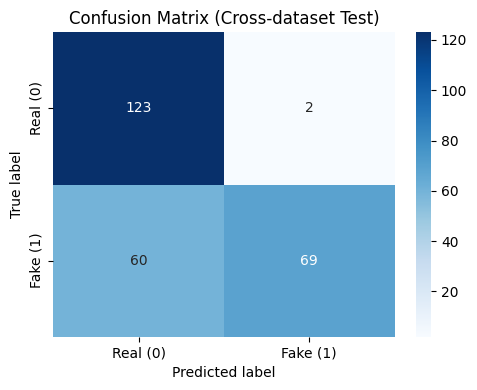


===== FALSE POSITIVES =====
Số tin thật bị nhầm thành tin giả: 2
Prob_fake: 0.9866
Đội cảnh sát có khả năng siêu nhớ mặt tại Anh. Năm 2009, một nghiên cứu do nhà tâm lý học Richard Russell thực hiện tại Đại học Harvard đặt ra giả thuyết rằng nếu tồn tại hội chứng mù mặt (tức những người gần như không có khả năng nhận diện khuôn mặt của người khác, thậm chí của bản thân) thì ắt hẳn sẽ có những người trái ngược hoàn toàn, tức là không bao giờ quên gương mặt của người mình từng gặp, dù chỉ nhìn qua một lần. Nhà nghiên cứu gọi những người này là "người siêu nhận diện".
Người siêu nhận diện chỉ chiếm khoảng 1-2% dân số. Họ có khả năng lưu trữ trong thời gian dài hơn 95% khuôn mặt mình đã gặp, trong khi người bình thường chỉ nhớ được khoảng 20%. Ngoài ra, người có thiên phú này có thể dễ dàng nhận diện khuôn mặt dù chỉ có thông tin không đầy đủ như vết sẹo, hình xăm, hoặc thậm chí là điệu bộ.
Wired cho hay cũng vào khoảng năm 2009, Mick Neville, một thanh tra ở Sở Cảnh sát London, đọc được 

In [1]:
import os
import shutil
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report
)

# =========================
# CONFIG
# =========================
SRC_MODEL_DIR = "/kaggle/input/phobert-ckpt2"
WORKING_MODEL_DIR = "/kaggle/working/final_model"

TEST_FILE = "/kaggle/input/test-data2/test_data1.csv"
TEXT_COL = "text"
LABEL_COL = "label"

BATCH_SIZE = 16
MAX_LEN = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================
# COPY MODEL TO WORKING DIR
# =========================
if os.path.exists(WORKING_MODEL_DIR):
    shutil.rmtree(WORKING_MODEL_DIR)

shutil.copytree(SRC_MODEL_DIR, WORKING_MODEL_DIR)
print(f"Model copied to: {WORKING_MODEL_DIR}")

# =========================
# LOAD TOKENIZER & MODEL
# =========================
tokenizer = AutoTokenizer.from_pretrained(
    WORKING_MODEL_DIR,
    local_files_only=True
)

model = AutoModelForSequenceClassification.from_pretrained(
    WORKING_MODEL_DIR,
    local_files_only=True
)

model.to(DEVICE)
model.eval()

# =========================
# LOAD TEST DATA
# =========================
df_test = pd.read_csv(TEST_FILE)

assert TEXT_COL in df_test.columns
assert LABEL_COL in df_test.columns

texts = df_test[TEXT_COL].astype(str).tolist()
labels = df_test[LABEL_COL].astype(int).to_numpy()

print(f" Test samples: {len(texts)}")
print("Label distribution:")
print(pd.Series(labels).value_counts())

# =========================
# PREDICTION (BATCHED)
# =========================
all_preds = []
all_probs = []

with torch.no_grad():
    for i in range(0, len(texts), BATCH_SIZE):
        batch_texts = texts[i:i+BATCH_SIZE]

        enc = tokenizer(
            batch_texts,
            truncation=True,
            padding=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        )

        input_ids = enc["input_ids"].to(DEVICE)
        attention_mask = enc["attention_mask"].to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)

        preds = torch.argmax(logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

preds = np.array(all_preds)
probs = np.array(all_probs)

# =========================
# METRICS
# =========================
acc = accuracy_score(labels, preds)
f1_macro = f1_score(labels, preds, average="macro")
f1_weighted = f1_score(labels, preds, average="weighted")
precision_macro = precision_score(labels, preds, average="macro")
recall_macro = recall_score(labels, preds, average="macro")

print("\n===== TEST METRICS (CROSS-DATASET) =====")
print(f"Accuracy          : {acc:.4f}")
print(f"F1 (macro)        : {f1_macro:.4f}")
print(f"F1 (weighted)     : {f1_weighted:.4f}")
print(f"Precision (macro) : {precision_macro:.4f}")
print(f"Recall (macro)    : {recall_macro:.4f}")

print("\nClassification Report:")
print(classification_report(labels, preds, digits=4))

# =========================
# CONFUSION MATRIX
# =========================
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Real (0)", "Fake (1)"],
    yticklabels=["Real (0)", "Fake (1)"]
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Cross-dataset Test)")
plt.tight_layout()
plt.show()

# =========================
# TIN THẬT BỊ NHẦM THÀNH TIN GIẢ
# =========================
df_test["pred"] = preds
df_test["prob_fake"] = probs[:, 1]

false_positive = df_test[
    (df_test[LABEL_COL] == 0) & (df_test["pred"] == 1)
].sort_values("prob_fake", ascending=False)

print("\n===== FALSE POSITIVES =====")
print(f"Số tin thật bị nhầm thành tin giả: {len(false_positive)}")

# Hiển thị 5 mẫu đầu
for i, row in false_positive.head(5).iterrows():
    print("=" * 100)
    print(f"Prob_fake: {row['prob_fake']:.4f}")
    print(row[TEXT_COL])

# =========================
# SAVE TO CSV (để phân tích thủ công)
# =========================
OUTPUT_FP = "/kaggle/working/false_positive_real_as_fake.csv"
false_positive.to_csv(OUTPUT_FP, index=False, encoding="utf-8-sig")

print(f"\nFalse Positive samples saved to: {OUTPUT_FP}")
